# The New York Social Graph


The goal of this project is to get familar with web scraping, data cleaning, and eventually making a graph network of social connections.

[New York Social Diary](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/) is a kind-of  voyeuristic view into New York's socially well-to-do. The data forms a natural social graph for New York's social elite, and such is an interesting dataset to play with.  An example is the this page of a [run-of-the-mill holiday party](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2014/holiday-dinners-and-doers). Please note that these links point to the internet archive, as the original website has recently removed most of its archives. Many of the images no longer load, but all the HTML is still there.

For the purpose of this project, the photos have carefully annotated captions labeling, which implicitly imply a social graph: there is a connection between two individuals if they appear in a picture together.

For this project, I'll assemble the social graph from photo captions for parties dated December 1, 2014 (arbitrary cut-off for filtering), and before.  Using this graph, I'll make guesses at the most popular socialites, the most influential people, and the most tightly coupled pairs.

I will attack the project in three phases:
1. Get a list of all the photo pages to be analyzed.
2. Parse all of the captions on a sample page.
3. Parse all of the captions on all pages, and assemble the graph.

## Phase One


The first step is to crawl the data. I want photos from parties on or before December 1st, 2014. I'll get the URL's and dates from the [Party Pictures Archive](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures) to see a list of (party) pages.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import dill
from bs4 import BeautifulSoup
from datetime import datetime as dt
import time
import re
import pandas as pd
import spacy
import numpy as np
import itertools
import operator
import seaborn as sns
sns.set()
plt.rcParams['figure.dpi'] = 144
nlp = spacy.load('en_core_web_sm')

I'll use Python [Requests](http://docs.python-requests.org/en/master/) to download the HTML pages, and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) to process the HTML.  I'll start by getting the [first page](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures). I added the user-agent as requests was returning a ClientError otherwise ([stackoverflow post](https://stackoverflow.com/questions/35137724/python-requests-client-error-bad-request-but-works-after-website-has-been-open)).

In [3]:
def soupify(wbpage):
    u_a = 'Mozilla/5.0 (X11; Linux x86_64)'
    page = requests.get(wbpage, headers={"USER-AGENT":u_a})
    if page.status_code != 200:
        print(f'status code: {page.status_code}')
    _soup = BeautifulSoup(page.text, 'lxml')
    return _soup

In [4]:
wbsite = 'https://web.archive.org/web/20190206202736/http://www.newyorksocialdiary.com/party-pictures'
soup = soupify(wbsite)

In [5]:
print(soup.prettify())

<!DOCTYPE html>
<!--[if IEMobile 7]><html class="no-js ie iem7" lang="en" dir="ltr"><![endif]-->
<!--[if lte IE 6]><html class="no-js ie lt-ie9 lt-ie8 lt-ie7" lang="en" dir="ltr"><![endif]-->
<!--[if (IE 7)&(!IEMobile)]><html class="no-js ie lt-ie9 lt-ie8" lang="en" dir="ltr"><![endif]-->
<!--[if IE 8]><html class="no-js ie lt-ie9" lang="en" dir="ltr"><![endif]-->
<!--[if (gte IE 9)|(gt IEMobile 7)]><html class="no-js ie" lang="en" dir="ltr" prefix="fb: http://ogp.me/ns/fb# og: http://ogp.me/ns# article: http://ogp.me/ns/article# book: http://ogp.me/ns/book# profile: http://ogp.me/ns/profile# video: http://ogp.me/ns/video# product: http://ogp.me/ns/product#"><![endif]-->
<!--[if !IE]><!-->
<html class="no-js" dir="ltr" lang="en" prefix="fb: http://ogp.me/ns/fb# og: http://ogp.me/ns# article: http://ogp.me/ns/article# book: http://ogp.me/ns/book# profile: http://ogp.me/ns/profile# video: http://ogp.me/ns/video# product: http://ogp.me/ns/product#">
 <!--<![endif]-->
 <head>
  <script src

This page has links to 50 party pages. I looked at the html to see if I can detect a pattern of where the URL's are located. It seems that the links are in the `div.views-row span.field-content a` tag. I will use BeautifulSoup's [select](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#css-selectors) method to get those elements.

In [8]:
def getlinks(_soup):
    link_divs = _soup.select('div.views-row span.field-content a') # The a only selects the links span
    reg_str = '<a href="(.*)">'
    print('Total links in tags:', len(link_divs))
    
    _cml =  [] # completed links
    for link in link_divs:
        cmp = re.findall(reg_str, str(link))
        #regex library takes only strins, so converted list object to string.
        _cml.append('https://web.archive.org{}'.format(cmp[0]))

    return _cml

In [7]:
cml = getlinks(soup)
print('The length of this URL list is:', len(cml), '\n')
print('First 5  urls are:\n')
for i in cml[0:5]:
    print(i)

Total links in tags: 50
The length of this URL list is: 50 

First 5  urls are:

https://web.archive.org/web/20190206202736/http://www.newyorksocialdiary.com/party-pictures/2019/jams-and-journeys
https://web.archive.org/web/20190206202736/http://www.newyorksocialdiary.com/party-pictures/2019/hanging-out-the-ham
https://web.archive.org/web/20190206202736/http://www.newyorksocialdiary.com/party-pictures/2018/gold-medal-winners
https://web.archive.org/web/20190206202736/http://www.newyorksocialdiary.com/party-pictures/2018/timeless-traditions
https://web.archive.org/web/20190206202736/http://www.newyorksocialdiary.com/party-pictures/2018/the-order-of-st-john-of-jerusalems-annual-charity-holiday-gala


I also want to get the assoicated dates with these links. This requires separting the same tag into URL and date fields.I used the `datetime.strptime` to extract dates as datetime objects.

In [10]:
def getdates(_soup):
    link_divs = _soup.select('div.views-row span.field-content')  
    # Unlike getlinks(), cannot exclusively select dates
    print('Length(URL + dates):', len(link_divs), end=' ')
    ti = int(len(link_divs)/2)
    link_divs2 = [i for i in range(ti)]
    for i in link_divs2:
        link_divs2[i] = link_divs[i*2+1]

    print(';  Length(dates):', len(link_divs2))

    reg_str = '<span class="field-content">\w*,(.*)<\/span>'
    cmp= list(range(0,ti))
    cmt= list(range(0,ti))

    for i in range(0,len(link_divs2)): #needed the range function as link_divs2 is not a list
        cmp[i] = re.findall(reg_str, str(link_divs2[i]))
        cmt[i] = dt.strptime(str(cmp[i]), "[' %B %d, %Y']")


    return cmp,cmt

In [11]:
cmp2, cmt = getdates(soup)
print('The length of this "date" list is:', len(cmp2), '\n')
print('First 5 dates are:\n', cmp2[0:5], '\n')
print('First 5 dates are:\n', cmt[0:5], '\n')

Length(URL + dates): 100 ;  Length(dates): 50
The length of this "date" list is: 50 

First 5 dates are:
 [[' January 17, 2019'], [' January 14, 2019'], [' December 28, 2018'], [' December 19, 2018'], [' December 19, 2018']] 

First 5 dates are:
 [datetime.datetime(2019, 1, 17, 0, 0), datetime.datetime(2019, 1, 14, 0, 0), datetime.datetime(2018, 12, 28, 0, 0), datetime.datetime(2018, 12, 19, 0, 0), datetime.datetime(2018, 12, 19, 0, 0)] 



Now I'll get all of the party URLs.  After looking at the index pages and seeing that subsequent pages have `?page=i` appended, I'll write a script to loop through all the pages and extract the party URLs.

In [17]:
cml, cmp2, cmt = [], [], []
wbsite  = 'https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures'


for i in range(0,27):
    if i == 0:
        wb2 = wbsite
    else:
        wb2 = wbsite+ f'?page={i}'
    print(f'URL count: {i}, URL page#: {i+1}')
    soup = soupify(wb2)

    cml = cml + getlinks(soup)

    cmpp2, cmtp = getdates(soup)
    cmp2 = cmp2 + cmpp2
    cmt = cmt + cmtp

    time.sleep(1) # was timing out as I may have been hitting the server too hard. Does slow down retrieval a lot.

URL count: 0, URL page#: 1
Total links in tags: 50
Length(URL + dates): 100 ;  Length(dates): 50
URL count: 1, URL page#: 2
Total links in tags: 50
Length(URL + dates): 100 ;  Length(dates): 50
URL count: 2, URL page#: 3
Total links in tags: 50
Length(URL + dates): 100 ;  Length(dates): 50
URL count: 3, URL page#: 4
Total links in tags: 50
Length(URL + dates): 100 ;  Length(dates): 50
URL count: 4, URL page#: 5
Total links in tags: 50
Length(URL + dates): 100 ;  Length(dates): 50
URL count: 5, URL page#: 6
Total links in tags: 50
Length(URL + dates): 100 ;  Length(dates): 50
URL count: 6, URL page#: 7
Total links in tags: 50
Length(URL + dates): 100 ;  Length(dates): 50
URL count: 7, URL page#: 8
Total links in tags: 50
Length(URL + dates): 100 ;  Length(dates): 50
URL count: 8, URL page#: 9
Total links in tags: 50
Length(URL + dates): 100 ;  Length(dates): 50
URL count: 9, URL page#: 10
Total links in tags: 50
Length(URL + dates): 100 ;  Length(dates): 50
URL count: 10, URL page#: 11


In [18]:
n = 0
print(cml[n], cmp2[n], cmt[n], sep='\n')

https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/kicks-offs-sing-offs-and-pro-ams
[' September 11, 2015']
2015-09-11 00:00:00


But we only want parties with dates on or before the first of December, 2014.  Let's write a function to filter our list of dates to those at or before a cutoff.  Using a keyword argument, we can put in a default cutoff, but allow us to test with others.

In [78]:
df = pd.DataFrame({'date': cmt,
                   'url': cml})
df = df[df['date'] <= '2014-12-01']
df.head()

,date,url
80,2014-12-01,https://web.archive.org/web/20150918040703/htt...
81,2014-11-24,https://web.archive.org/web/20150918040703/htt...
82,2014-11-20,https://web.archive.org/web/20150918040703/htt...
83,2014-11-18,https://web.archive.org/web/20150918040703/htt...
84,2014-11-17,https://web.archive.org/web/20150918040703/htt...


In the end, I had about 1213 pages. I saved the url list as a text file, as well as a serialized object using the `dill` package so I don't have to re-hit the server every time and just start from here. To restore the list, I can either read the `txt` file or import the `pkd` file.

In [79]:
# you want the one or the other to be commented out
#dill.dump(df, open('df_all_urls.pkd', 'wb'))
df = dill.load(open('df_all_urls.pkd', 'rb'))

## Checkpost 1: Histogram

Just to explore the data, let's see the number of parties per month. A histogram is probably the best way to visualize the data. I also output the histogram values into a tuple, if I want to look up the exact numbers, or export them.

There may be a cleverer way of changing from the full date to a year-month datetime object (for binning), but I couldn't find one, so I did a two-step procedure:

In [84]:
df['mY'] = df['date'].dt.strftime('%b-%Y')
df['mY'] = pd.to_datetime(df['mY'], format='%b-%Y')

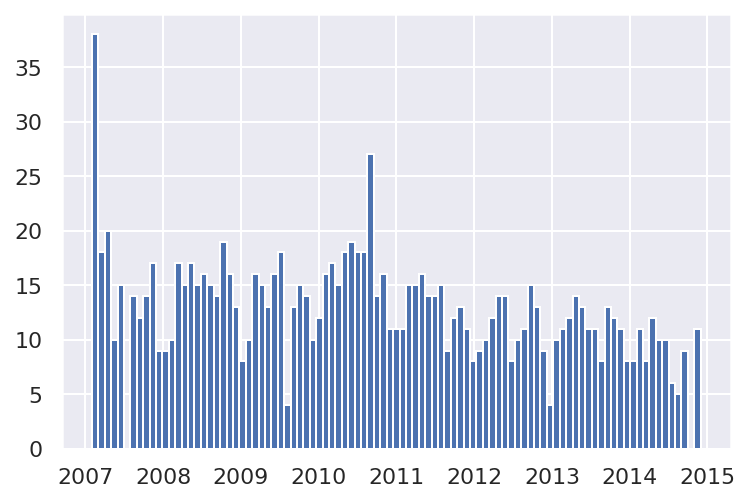

In [112]:
plt.hist(df['mY'], bins=len(df['mY'].unique()))
plt.show()

In [110]:
df_grp = df.groupby(['mY'], as_index=False)
grp_ct = df_grp['mY'].size().tolist()

hgram = []
for i,j in zip(df_grp, grp_ct):
    hgram.append((dt.strftime(i[0],'%Y-%m'), j))

print(len(hgram))
print(hgram[0:5])

95
[('2007-02', 2), ('2007-03', 36), ('2007-04', 18), ('2007-05', 20), ('2007-06', 10)]


## Phase Two

In this phase, I will concentrate on getting the names out of captions for a given page. This is not exactly a precise procedure, but the hope is to find enough structure in each page to extract the captions (via BeautifulSoup), separate multiple names (regex), and parse them out from non-name words (using the Spacy NLP library).

In [113]:
# getting the url list for parsing
url_list = df['url'].tolist()
fid = open('url.txt', 'w')

for i in url_list:
    fid.write(f'{i}\n')

In [12]:
# you want the one or the other to be commented out
# dill.dump(url_list, open('url_list.pkd', 'wb'))
url_list = dill.load(open('url_list.pkd', 'rb'))

In [ ]:
# Need this function as soup objects don't serialize well. 
# So I'll scrape the individual pages and save them for offline access

def pre_soup(wbpage):
    u_a = 'Mozilla/5.0 (X11; Linux x86_64)'
    page = requests.get(wbpage, headers={"USER-AGENT":u_a})
    if page.status_code != 200:
        print(f'status code: {page.status_code}')
    return page.text


In [ ]:
all_pages = []
for i,j in enumerate(url_list):
    all_pages.append(pre_soup(j))
    if i%10 == 0:
        print(i)

I am saving the retrieved pages before I use the `BeautifulSoup`. This is mostly because [serializing Soup ojbects can lead to failures](https://stackoverflow.com/questions/24563148/beautifulsoup-object-will-not-pickle-causes-interpreter-to-silently-crash), so its easier to save the retrieved pages.

In [ ]:
# dill.dump(all_pages, open('all_pages.pkd', 'wb'))
all_pages = dill.load(open('all_pages.pkd', 'rb'))

In [ ]:
    def getcaptions(_soup):
        link_td = _soup.select('td.photocaption') # For graph 2 question
        link_div = _soup.select('div.photocaption')  # For graph 2 question alternate selection
        all_links = link_td + link_div
        
        pat_div = '<div.*?>(.*)<\/div>'
        pat_td = '<td.*?>(.*)<\/td>'
        cml = []
        
        for i in all_links:
            cmp = re.findall(pat_div, str(i))
            if not cmp:
                cmp = re.findall(pat_td, str(i))
            cml.append(cmp)

        return cml

In [ ]:

def strip_clean(_cmp):
    for i in _cmp:
        if not i: #added this as otherwise indexing would choke on an empty list item
            #print('cmp[',i,'] is an empty array')
            continue
        elif len(i[0]) > 250:
            #print('Greater than 250 characters. skipping it')
            continue
        else:
            reg_str = '^\s'
            i[0] = re.sub(reg_str, '', i[0])

            reg_str = '\s$'
            i[0] = re.sub(reg_str, '', i[0])

            if ' at ' in i[0]:
                reg_str = '\sat\s.*'
                i[0] = re.sub(reg_str, '', i[0])

            if '(' in i[0]:
                #print('Removed a parenthesis from ', i)
                reg_str = '\(.*\)'
                i[0] = re.sub(reg_str, '', i[0])

            if 'and friend' in i[0]:
                #print("Removing 'and friend(s)' from this item:", i)
                reg_str = '\sand\sfriends*'
                i[0] = re.sub(reg_str, '', i[0])
    return _cmp

In [ ]:
def split_names(cmp):
    nms = {}
    for i in range(0,len(cmp)): # putting each name into its own list
        nms[i] = {}
        # print(i)
        if not cmp[i]: #added this as otherwise indexing would choke on an empty list item
            continue
            #print('cmp[',i,'] is an empty array')
        elif len(cmp[i][0]) > 250:
            continue
            #print('Greater than 250 characters. skipping it')
        elif not(',' in cmp[i][0]):

            if ' Jr.' in cmp[i][0]: #added this to deal with ,Jr. supposedly
                #print("Removing ' Jr. ' from this item:", cmp[i][0])
                reg_str = '\sJr\.'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if ' MD' in cmp[i][0]:
                #print("Removing 'MD ' from this item:", cmp[i][0])
                reg_str = '\sMD'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if ' M.D.' in cmp[i][0]:
                #print("Removing 'M.D. ' from this item:", cmp[i][0])
                reg_str = '\s*M\.D\.'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if ' M D' in cmp[i][0]:
                #print("Removing 'M.D. ' from this item:", cmp[i][0])
                reg_str = '\s*M\sD'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            reg_str = '^([^\s]+)\s+and\s+([^\s]+)\s+([^\s]+)$' # separating 'first and first last' name format
            if not(' and ' in cmp[i][0]): # means just a single name in this caption
                nms[i][0] = (cmp[i][0])
            elif re.search(reg_str, cmp[i][0]):
                rout = re.findall(reg_str, cmp[i][0])
                nms[i] = {}
                nms[i][0] = rout[0][0] + ' ' + rout[0][2]
                nms[i][1] = rout[0][1] + ' ' + rout[0][2]
                #print('Split this first and first last name for', i)
            else:
                #print('Split these two names caption for', i, cmp[i])
                ln1 = cmp[i][0].split(' and ') #list of names 1 and 2
                nms[i] = {}
                nms[i][0] = ln1[0]
                nms[i][1] = ln1[1]
        else:
            if ' Jr.' in cmp[i][0]: #added this to deal with ,Jr. supposedly
                #print("Removing ' Jr. ' from this item:", cmp[i][0])
                reg_str = '\sJr\.'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if 'MD' in cmp[i][0]:
                #print("Removing 'MD ' from this item:", cmp[i][0])
                reg_str = '\sMD'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if 'M.D.' in cmp[i][0]:
                #print("Removing 'M.D. ' from this item:", cmp[i][0])
                reg_str = '\s*M\.D\.'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if ' M D' in cmp[i][0]:
                #print("Removing 'M.D. ' from this item:", cmp[i][0])
                reg_str = '\s*M\sD'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            ln = cmp[i][0].split(', ') # list of names assuming separated by comma
            for j in range(0,len(ln)):
                if 'and ' in ln[j]:
                    ln[j] = re.sub('and\s', '', ln[j])
                nms[i][j] = ln[j]
    return nms

In [ ]:
soup = BeautifulSoup(all_pages[3], 'lxml')
cmp = getcaptions(soup)
cmp = strip_clean(cmp)
nms = split_names(cmp)

In [ ]:
nms

In [ ]:
def clean_things(nms):


    for i in nms:
        if 'and ' in nms[i]:
            print("Removing 'and' from from of this item:", nms[i])
            reg_str = '^and\s'
            nms[i] = re.sub(reg_str, '', nms[i])

        if 'with ' in nms[i]:
            print("Removing 'with' from from of this item:", nms[i])
            reg_str = ' with '
            nms[i], nms[nml] = nms[i].split(reg_str)

        if 'Dr. ' in nms[i]:
            print("Removing 'Dr. ' from this item", nms[i])
            reg_str = '^Dr\.\s'
            nms[i] = re.sub(reg_str, '', nms[i])

        if 'Mr. ' in nms[i]:
            print("Removing 'Mr. ' from this item:", nms[i])
            reg_str = '^Mr\.\s'
            nms[i] = re.sub(reg_str, '', nms[i])

        if 'Mrs. ' in nms[i]:
            print("Removing 'Mrs. ' from this item:", nms[i])
            reg_str = '^Mrs\.\s'
            nms[i] = re.sub(reg_str, '', nms[i])

        if 'Esq.' in nms[i]:
            print("Removing 'Esq. ' from this item:", nms[i])
            reg_str = '\s*Esq\.$'
            nms[i] = re.sub(reg_str, '', nms[i])

        if ' on ' in nms[i]:
            print("Removing anything after ' on ' from this item:", nms[i])
            reg_str = '\son\s.*$'
            nms[i] = re.sub(reg_str, '', nms[i])
            
    return nms

In [ ]:
nms = clean_things(nms)

In [ ]:

nmu = {} # unique name list

for key, value in nms.items():
    if value not in nmu.values():
        nmu[key] = value


nm_out = sorted(nms.values())
nm_out2 = sorted(nmu.values())
print(nm_out)
print(nm_out2[2:102])
#print(nmu)

for i in range(len(nm_out2)):
    print(nm_out2[i])



In [ ]:
captions = ...

By our count, there are about 110.  But if you're off by a couple, you're probably okay.

In [ ]:
assert abs(len(captions) - 110) < 5

Let's encapsulate this in a function.  As with the links pages, we want to avoid downloading a given page the next time we need to run the notebook.  While we could save the files by hand, as we did before, a checkpoint library like [ediblepickle](https://pypi.python.org/pypi/ediblepickle/1.1.3) can handle this for you.  (Note, though, that you may not want to enable this until you are sure that your function is working.)

You should also keep in mind that HTTP requests fail occasionally, for transient reasons.  You should plan how to detect and react to these failures.   The [retrying module](https://pypi.python.org/pypi/retrying) is one way to deal with this.

In [ ]:
def get_captions(path):
    ...

This should get the same captions as before.

In [ ]:
assert captions == get_captions("/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood")

Now that we have some sample captions, let's start parsing names out of those captions.  There are many ways of going about this, and we leave the details up to you.  Some issues to consider:

  1. Some captions are not useful: they contain long narrative texts that explain the event.  Try to find some heuristic rules to separate captions that are a list of names from those that are not.  A few heuristics include:
    - look for sentences (which have verbs) and as opposed to lists of nouns. For example, [`nltk` does part of speech tagging](http://www.nltk.org/book/ch05.html) but it is a little slow. There may also be heuristics that accomplish the same thing.
    - Similarly, spaCy's [entity recognition](https://spacy.io/docs/usage/entity-recognition) could be useful here.
    - Look for commonly repeated threads (e.g. you might end up picking up the photo credits or people such as "a friend").
    - Long captions are often not lists of people.  The cutoff is subjective, but for grading purposes, *set that cutoff at 250 characters*.
  2. You will want to separate the captions based on various forms of punctuation.  Try using `re.split`, which is more sophisticated than `string.split`. **Note**: The reference solution uses regex exclusively for name parsing.
  3. You might find a person named "ra Lebenthal".  There is no one by this name.  Can anyone spot what's happening here?
  4. This site is pretty formal and likes to say things like "Mayor Michael Bloomberg" after his election but "Michael Bloomberg" before his election.  Can you find other ('optional') titles that are being used?  They should probably be filtered out because they ultimately refer to the same person: "Michael Bloomberg."
  5. There is a special case you might find where couples are written as eg. "John and Mary Smith". You will need to write some extra logic to make sure this properly parses to two names: "John Smith" and "Mary Smith".
  6. When parsing names from captions, it can help to look at your output frequently and address the problems that you see coming up, iterating until you have a list that looks reasonable. This is the approach used in the reference solution. Because we can only asymptotically approach perfect identification and entity matching, we have to stop somewhere.
  
**Questions worth considering:**
  1. Who is Patrick McMullan and should he be included in the results? How would you address this?
  2. What else could you do to improve the quality of the graph's information?

## Question 2: sample_names


Once you feel that your algorithm is working well on these captions, parse all of the captions and extract all the names mentioned.  Sort them alphabetically, by first name, and return the first hundred.

In [ ]:
sample_names = ["Caroline Dean"] * 100


Now, run this sort of test on a few other pages.  You will probably find that other pages have a slightly different HTML structure, as well as new captions that trip up your caption parser.  But don't worry if the parser isn't perfect -- just try to get the easy cases.

## Phase Three


Once you are satisfied that your caption scraper and parser are working, run this for all of the pages.  If you haven't implemented some caching of the captions, you probably want to do this first.

In [ ]:
def clean_things(nmi):
    
    reg_str = '<.*?>'
    nmi = re.sub(reg_str, '', nmi)
    
    if 'and ' in nmi:
        #print("Removing 'and' from from of this item:", nmi)
        reg_str = '^and\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'with ' in nmi:
        #print("Removing 'with' from from of this item:", i, nmi)
        reg_str = ' with '
        nmi = nmi.split(reg_str)

    if 'Mayor ' in nmi:
        #print("Removing 'Mayor ' from this item", nmi)
        reg_str = '^Mayor\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'President ' in nmi:
        #print("Removing 'President ' from this item", nmi)
        reg_str = '^President\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'Consul General ' in nmi:
        #print("Removing 'Consul General ' from this item", nmi)
        reg_str = '^Consul General\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'Sir ' in nmi:
        #print("Removing 'Sir ' from this item", nmi)
        reg_str = '^Sir\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'HRH Princess ' in nmi:
        #print("Removing 'HRH Princess ' from this item", nmi)
        reg_str = '^HRH\sPrincess\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'Ambassador ' in nmi:
        #print("Ambassador ' from this item", nmi)
        reg_str = '^Ambassador\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'Dr. ' in nmi:
        #print("Removing 'Dr. ' from this item", nmi)
        reg_str = '^Dr\.\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'Mr. ' in nmi:
        #print("Removing 'Mr. ' from this item:", nmi)
        reg_str = '^Mr\.\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'Mrs. ' in nmi:
        #print("Removing 'Mrs. ' from this item:", nmi)
        reg_str = '^Mrs\.\s'
        nmi = re.sub(reg_str, '', nmi)

    if 'Esq.' in nmi:
        #print("Removing 'Esq. ' from this item:", nmi)
        reg_str = '\s*Esq\.$'
        nmi = re.sub(reg_str, '', nmi)

    # if 'MD' in nmi:
    #     #print("Removing 'MD ' from this item:", nmi)
    #     reg_str = '\sMD$'
    #     nmi = re.sub(reg_str, '', nmi)

    if 'M.D.' in nmi:
        #print("Removing 'M.D. ' from this item:", nmi)
        reg_str = '\s*M\.D\.$'
        nmi = re.sub(reg_str, '', nmi)

    if 'Jr.' in nmi:
        #print("Removing 'Jr. ' from this item:", nmi)
        reg_str = '\s*Jr\.$'
        nmi = re.sub(reg_str, '', nmi)

    if ' on ' in nmi:
        #print("Removing anything after ' on ' from this item:", nmi)
        reg_str = '\son\s.*$'
        nmi = re.sub(reg_str, '', nmi)

    if ' examining ' in nmi:
        #print("Removing anything after ' examining ' from this item:", nmi)
        reg_str = '\sexamining\s.*$'
        nmi = re.sub(reg_str, '', nmi)

    if 'Mr.' in nmi or 'Mrs.' in nmi: #order matters, after the other Mrs. one
        #print("Deleting this entry:", i,',',nmi)
        #del nmi
        nmi = {}

    return nmi

In [ ]:
j = 0
for i in nms:
    print(nms[i])
    j += 1
    if j == 3:
        break

In [ ]:
nms

In [ ]:
for i in nms:
    for j in nms[i]:
        print(nms[i][j])
        if nms[i][j]:
            nms[i][j] = clean_things(nms[i][j])
            nms[i][j] = sp_nlp(nms[i][j])

In [ ]:
for i in nms:
    print(nms[i])

In [ ]:
    def sp_nlp(nmi):
        doc = nlp(nmi)
        in_tok_n = [] #token is noun
        tok_n = np.array(in_tok_n)
        j = 0
        deli = 0
        for token in doc:
            if token.pos_ == 'PROPN':
                tok_n = np.append(tok_n, 1)
            else:
                #tok_n[j] = 0
                tok_n = np.append(tok_n, 0)
            j = j+1

        if np.mean(tok_n) < 0.5:
            #print('\n', token.text, '\n', token.pos_, '\n', nmi)
            deli = 1 #delete_item
        return deli

In [ ]:


def graph3all(soup):
    cmp = getcaptions(soup)
    cmp = strip_clean(cmp)
    nms = split_names(cmp)
    #print('\nProcessing Round 1\n')



    #print('\nCleaning up the list. Dangerous, be careful:\n')
    #print('nms list before cleaning round 2:\n', nms)

    # nmi is nms item


    nml = len(nms)
    for i in range(nml):
        nmk = len(nms[i])
        for j in range(nmk):
            nmt = clean_things(nms[i][j]) # nm_temp
            #print(nmt)
            if len(nmt) == 2:
                nmk = len(nms[i])
                nms[i][nmk] = nmt[1]
                nms[i][j] = nmt[0]
            elif len(nmt) == 1:
                nms[i][j] = nmt[0]
            elif len(nmt) == 0:
                del nms[i][j]


    #print('\nAfter the looping change:')

    #for i,j in nms.items():
        #print(i, j)

    #cleaning
    for l,i in nms.items():
        k = 0
        new_dict = {}
        for j in i:
            new_dict[k] = i[j]
            k += 1
        nms[l] = new_dict

    #print('\n\n\nWith cleaning stuff:')
    #for i,j in nms.items():
        #print(i, j)

    nml = len(nms)
    for i in range(nml):
        nmk = len(nms[i])
        for j in range(nmk):
            nmt = clean_things(nms[i][j]) # nm_temp
            #print(nmt)
            if len(nmt) == 2:
                nmk = len(nms[i])
                nms[i][nmk] = nmt[1]
                nms[i][j] = nmt[0]
            elif len(nmt) == 1:
                nms[i][j] = nmt[0]
            elif len(nmt) == 0:
                del nms[i][j]

    #cleaning
    for l,i in nms.items():
        k = 0
        new_dict = {}
        for j in i:
            new_dict[k] = i[j]
            k += 1
        nms[l] = new_dict


    #print('\nAfter re-indexing change:', nms)


#spacey definition was here

    del_ar = []

    for m,i in nms.items():
        for j,k in i.items():
            deli = sp_nlp(k)
            if deli == 1:
                del_ar.append([m,j])


    #print(del_ar)
    for i in del_ar:
        del nms[i[0]][i[1]]
        ##print(i[0])

    #print('\nnms list after NLP:\n')
    #for i,j in nms.items():
        #print(j)
    ##print('\nnms list after NLP:', nms, '\n')
    #print('nms list length after NLP:', len(nms), '\n')


#cleaning
    for l,i in nms.items():
        k = 0
        new_dict = {}
        for j in i:
            new_dict[k] = i[j]
            k += 1
        nms[l] = new_dict

    return nms

#########################################


In [ ]:


def graph3all(soup):
    cmp = getcaptions()
    #print('\nProcessing Round 1\n')

    nms = {} #names list




    #print('\nThis is the list after spaces and other things are removed:\n')
    #for i in range(ti):
        #print(i, cmp[i])

    #print('\nSplitting names into separate items:\n')

    for i in range(0,ti): # putting each name into its own list
        nms[i] = {}
        # print(i)
        if not cmp[i]: #added this as otherwise indexing would choke on an empty list item
            continue
            #print('cmp[',i,'] is an empty array')
        elif len(cmp[i][0]) > 250:
            continue
            #print('Greater than 250 characters. skipping it')
        elif not(',' in cmp[i][0]):

            if ' Jr.' in cmp[i][0]: #added this to deal with ,Jr. supposedly
                #print("Removing ' Jr. ' from this item:", cmp[i][0])
                reg_str = '\sJr\.'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if ' MD' in cmp[i][0]:
                #print("Removing 'MD ' from this item:", cmp[i][0])
                reg_str = '\sMD'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if ' M.D.' in cmp[i][0]:
                #print("Removing 'M.D. ' from this item:", cmp[i][0])
                reg_str = '\s*M\.D\.'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if ' M D' in cmp[i][0]:
                #print("Removing 'M.D. ' from this item:", cmp[i][0])
                reg_str = '\s*M\sD'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            reg_str = '^([^\s]+)\s+and\s+([^\s]+)\s+([^\s]+)$' # separating 'first and first last' name format
            if not(' and ' in cmp[i][0]): # means just a single name in this caption
                nms[i][0] = (cmp[i][0])
            elif re.search(reg_str, cmp[i][0]):
                rout = re.findall(reg_str, cmp[i][0])
                nms[i] = {}
                nms[i][0] = rout[0][0] + ' ' + rout[0][2]
                nms[i][1] = rout[0][1] + ' ' + rout[0][2]
                #print('Split this first and first last name for', i)
            else:
                #print('Split these two names caption for', i, cmp[i])
                ln1 = cmp[i][0].split(' and ') #list of names 1 and 2
                nms[i] = {}
                nms[i][0] = ln1[0]
                nms[i][1] = ln1[1]
        else:
            if ' Jr.' in cmp[i][0]: #added this to deal with ,Jr. supposedly
                #print("Removing ' Jr. ' from this item:", cmp[i][0])
                reg_str = '\sJr\.'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if 'MD' in cmp[i][0]:
                #print("Removing 'MD ' from this item:", cmp[i][0])
                reg_str = '\sMD'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if 'M.D.' in cmp[i][0]:
                #print("Removing 'M.D. ' from this item:", cmp[i][0])
                reg_str = '\s*M\.D\.'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            if ' M D' in cmp[i][0]:
                #print("Removing 'M.D. ' from this item:", cmp[i][0])
                reg_str = '\s*M\sD'
                cmp[i][0] = re.sub(reg_str, '', cmp[i][0])

            ln = cmp[i][0].split(', ') # list of names assuming separated by comma
            for j in range(0,len(ln)):
                if 'and ' in ln[j]:
                    ln[j] = re.sub('and\s', '', ln[j])
                nms[i][j] = ln[j]
                #print(nms[i][j])
            #print('Splitting these comma separated names for', i)

    #print(nms)

    #print('\nCleaning up the list. Dangerous, be careful:\n')
    #print('nms list before cleaning round 2:\n', nms)

    # nmi is nms item


    nml = len(nms)
    for i in range(nml):
        nmk = len(nms[i])
        for j in range(nmk):
            nmt = clean_things(nms[i][j]) # nm_temp
            #print(nmt)
            if len(nmt) == 2:
                nmk = len(nms[i])
                nms[i][nmk] = nmt[1]
                nms[i][j] = nmt[0]
            elif len(nmt) == 1:
                nms[i][j] = nmt[0]
            elif len(nmt) == 0:
                del nms[i][j]


    #print('\nAfter the looping change:')

    #for i,j in nms.items():
        #print(i, j)

    #cleaning
    for l,i in nms.items():
        k = 0
        new_dict = {}
        for j in i:
            new_dict[k] = i[j]
            k += 1
        nms[l] = new_dict

    #print('\n\n\nWith cleaning stuff:')
    #for i,j in nms.items():
        #print(i, j)

    nml = len(nms)
    for i in range(nml):
        nmk = len(nms[i])
        for j in range(nmk):
            nmt = clean_things(nms[i][j]) # nm_temp
            #print(nmt)
            if len(nmt) == 2:
                nmk = len(nms[i])
                nms[i][nmk] = nmt[1]
                nms[i][j] = nmt[0]
            elif len(nmt) == 1:
                nms[i][j] = nmt[0]
            elif len(nmt) == 0:
                del nms[i][j]

    #cleaning
    for l,i in nms.items():
        k = 0
        new_dict = {}
        for j in i:
            new_dict[k] = i[j]
            k += 1
        nms[l] = new_dict


    #print('\nAfter re-indexing change:', nms)


    def sp_nlp(nmi):
        doc = nlp(nmi)
        in_tok_n = [] #token is noun
        tok_n = np.array(in_tok_n)
        j = 0
        deli = 0
        for token in doc:
            if token.pos_ == 'PROPN':
                tok_n = np.append(tok_n, 1)
            else:
                #tok_n[j] = 0
                tok_n = np.append(tok_n, 0)
            j = j+1

        if np.mean(tok_n) < 0.5:
            #print('\n', token.text, '\n', token.pos_, '\n', nmi)
            deli = 1 #delete_item
        return deli

    del_ar = []

    for m,i in nms.items():
        for j,k in i.items():
            deli = sp_nlp(k)
            if deli == 1:
                del_ar.append([m,j])


    #print(del_ar)
    for i in del_ar:
        del nms[i[0]][i[1]]
        ##print(i[0])

    #print('\nnms list after NLP:\n')
    #for i,j in nms.items():
        #print(j)
    ##print('\nnms list after NLP:', nms, '\n')
    #print('nms list length after NLP:', len(nms), '\n')


#cleaning
    for l,i in nms.items():
        k = 0
        new_dict = {}
        for j in i:
            new_dict[k] = i[j]
            k += 1
        nms[l] = new_dict

    return nms

#########################################


In [ ]:

all_pages = dill.load(open('link_soups.pkd', 'rb'))
#all_pages = dill.load(open('notallpages.pkd', 'rb'))

nmp = []

for k in range(len(all_pages)):
    wbsite = all_pages[k]
    soup = BeautifulSoup(wbsite.text, 'lxml')
    nms = graph3all(soup)

    for i in nms.values():
        nmj = list(itertools.combinations(i.values(), 2))
        for j in nmj:
            nmp.append(j)

##print(missed_pages)
dill.dump(nmp, open('nmp_new.pkd', 'wb'))

#dill.dump(nms, open('nms1_list.pkd', 'wb'))
# #dill.dump(nm_out2, open('p1_name_list.pkd', 'wb'))

In [ ]:
# Scraping all of the pages could take 10 minutes or so.

For the remaining analysis, we think of the problem in terms of a
[network](http://en.wikipedia.org/wiki/Computer_network) or a
[graph](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29).  Any time a pair of people appear in a photo together, that is considered a link.  What we have described is more appropriately called an (undirected)
[multigraph](http://en.wikipedia.org/wiki/Multigraph) with no self-loops but this has an obvious analog in terms of an undirected [weighted graph](http://en.wikipedia.org/wiki/Graph_%28mathematics%29#Weighted_graph).  In this problem, we will analyze the social graph of the New York social elite.  We recommend using python's [`networkx`](https://networkx.github.io/) library.

In [ ]:
import itertools  # itertools.combinations may be useful
import networkx as nx

All in all, you should end up with over 100,000 captions and more than 110,000 names, connected in about 200,000 pairs.

## Checkpoint 3: degree


The simplest question to ask is "who is the most popular"?  The easiest way to answer this question is to look at how many connections everyone has.  Return the top 100 people and their degree.  Remember that if an edge of the graph has weight 2, it counts for 2 in the degree.

**Checkpoint:** Some aggregate stats on the solution

    "count": 100.0
    "mean": 189.92
    "std": 87.8053034454
    "min": 124.0
    "25%": 138.0
    "50%": 157.0
    "75%": 195.0
    "max": 666.0

In [ ]:


#nms = dill.load(open('nms1_list.pkd', 'rb'))
nmp1 = dill.load(open('nmp_new.pkd', 'rb'))
nmp2 = dill.load(open('nmp_new_td.pkd', 'rb'))


print('Size of nmp is:', len(nmp1))
print('Size of nmp is:', len(nmp2))
nmp = nmp1 + nmp2
print('Size of nmp is:', len(nmp))


#nmp = nmp[0:80000]
G=nx.Graph()


# for i in nmp:
#     #print(i)
#     if not 'Jr.' in i or 'M.D.' in i:
#         if G.has_edge(i[0],i[1]):
#             G.edges[i[0], i[1]]['weight'] += 1
#             #print(G.edges[i[0], i[1]]['weight'])
#         else:
#             G.add_edge(*i, weight = 1)

for i in nmp:
    #print(i)
    if G.has_edge(i[0],i[1]):
        G.edges[i[0], i[1]]['weight'] += 1
            #print(G.edges[i[0], i[1]]['weight'])
    else:
        G.add_edge(*i, weight = 1)


In [ ]:
nd = G.degree
sorted_nd = sorted(nd, key=operator.itemgetter(1))
sorted_nd.reverse()
print(sorted_nd[0:100])

nd_50 = []
for i in sorted_nd:
    nd_50.append((i[0], int(i[1]*1.2)))
print(nd_50[0:100])

In [ ]:
import heapq  # Heaps are efficient structures for tracking the largest
              # elements in a collection.  Use introspection to find the
              # function you need.
degree = [('Alec Baldwin', 144)] * 100


## Checkpoint 4: PageRank


A similar way to determine popularity is to look at their
[PageRank](http://en.wikipedia.org/wiki/PageRank).  PageRank is used for web ranking and was originally
[patented](http://patft.uspto.gov/netacgi/nph-Parser?patentnumber=6285999) by Google and is essentially the stationary distribution of a [Markov
chain](http://en.wikipedia.org/wiki/Markov_chain) implied by the social graph. You can implement this yourself or use the version in `networkx`

Use 0.85 as the damping parameter so that there is a 15% chance of jumping to another vertex at random.

**Checkpoint:** Some aggregate stats on the solution

    "count": 100.0
    "mean": 0.0001841088
    "std": 0.0000758068
    "min": 0.0001238355
    "25%": 0.0001415028
    "50%": 0.0001616183
    "75%": 0.0001972663
    "max": 0.0006085816

In [ ]:

pr = nx.pagerank(G)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1))
sorted_pr.reverse()
print(sorted_pr[0:100])

In [ ]:
pagerank = [('Martha Stewart', 0.00019312108706213307)] * 100


## Checkpoint 5: best_friends


Another interesting question is who tend to co-occur with each other.  Give us the 100 edges with the highest weights.

Google these people and see what their connection is.  Can we use this to detect instances of infidelity?

**Checkpoint:** Some aggregate stats on the solution

    "count": 100.0
    "mean": 25.84
    "std": 16.0395470855
    "min": 14.0
    "25%": 16.0
    "50%": 19.0
    "75%": 29.25
    "max": 109.0

In [ ]:

ct = 0
bf = []
for (u,v,d) in G.edges(data='weight'):
    if d >9:
        #print(u, v, d)
        bf.append(((u, v), d))
        ct += 1

sorted_bf = sorted(bf, key=operator.itemgetter(1))
sorted_bf.reverse()
print(sorted_bf[3:103])

In [ ]:
best_friends = [(('Michael Kennedy', 'Eleanora Kennedy'), 41)] * 100



*Copyright &copy; 2019 The Data Incubator.  All rights reserved.*